In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import tools.config as config
import matplotlib.pyplot as plt


# 1. 使用 Seaborn 设置基础网格和颜色主题
sns.set_theme(style="darkgrid")

# 2. 设置常规文本字体 (例如 Arial)
#    这会影响标题、坐标轴标签等非 mathtext 元素
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# 3. 将可能被修改过的 mathtext 设置恢复到 Matplotlib 的默认状态。
#    这是一个安全的赋值操作，而不是不稳定的 pop 操作。
#    默认的 mathtext 字体是 'dejavusans'，默认模式是 'it' (斜体)。
mpl.rcParams['mathtext.rm'] = 'dejavusans'
mpl.rcParams['mathtext.default'] = 'it'

# 4. 现在，覆盖 mathtext 的字体集，让它使用与 Arial 外观相似的 'stixsans'。
#    这是实现字体统一外观的关键步骤，并且非常稳定。
plt.rcParams['mathtext.fontset'] = 'stixsans'

# 5. 应用您其他的自定义样式
plt.rcParams.update({
    "xtick.bottom": True, "ytick.left": True,
    "xtick.top": False, "ytick.right": False,
    "xtick.direction": "out", "ytick.direction": "out",
    "xtick.major.size": 4, "ytick.major.size": 4,
    "xtick.major.width": 1.2, "ytick.major.width": 1.2,
})


def set_plot_style(font_size=12, font_family='Arial'):
    """
    统一设置 Matplotlib 的全局绘图风格。

    这个函数会更新 rcParams，以确保图表中的所有文本元素
    （标题、标签、刻度、图例等）都使用一致的字体和大小。

    参数:
        font_size (int): 基础字号，应用于所有文本元素。
        font_family (str): 字体族，例如 'Arial', 'Helvetica', 'Times New Roman'。
    """
    # mpl.rcParams.update() 是一种高效地一次性更新多个参数的方法。
    mpl.rcParams.update({
        # --- 全局字体设置 ---
        'font.size': font_size,  # 设置基础字号
        'font.family': 'sans-serif',  # 推荐设置字体“族”为无衬线
        'font.sans-serif': [font_family, 'DejaVu Sans'],  # 提供一个字体备选列表，Arial优先

        # --- 坐标轴(Axes)相关字体大小 ---
        'axes.titlesize': font_size,  # 子图标题 (ax.set_title())
        'axes.labelsize': font_size,  # 子图X/Y轴标签 (ax.set_xlabel())

        # --- 刻度(Ticks)相关字体大小 ---
        'xtick.labelsize': font_size,  # X轴刻度标签
        'ytick.labelsize': font_size,  # Y轴刻度标签

        # --- 图例(Legend)字体大小 ---
        'legend.fontsize': font_size,

        # --- 图表(Figure)级别字体大小 ---
        # 这个参数同时控制 fig.suptitle() 和 fig.supylabel()
        'figure.titlesize': font_size
    })


set_plot_style(font_size=12)

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_excels_as_grid(excel_paths, titles=None, row_labels=None,
                        figsize=(12, 9), save_path=None, add_fit_row=True):
    """
    - Excel 第一列作为 index（年份） → x 轴
    - 后三列为 y（每列单独成图，纵向排列）
    - 同一行共享 y 轴
    - 若 add_fit_row=True，则新增第4行：对“第3列”进行二次多项式拟合（seaborn.regplot, order=2, ci=95）
    """
    n = len(excel_paths)
    if n == 0:
        raise ValueError("excel_paths 不能为空。")

    dfs = []
    for p in excel_paths:
        df = pd.read_excel(p, index_col=0)
        if 'config' in globals() and hasattr(config, 'START_YEAR'):
            df = df.loc[df.index >= config.START_YEAR].copy()
        if df.shape[1] < 3:
            raise ValueError(f"{p} 至少需要 3 列 y 数据。")
        dfs.append(df)

    if titles is None:
        titles = [os.path.splitext(os.path.basename(p))[0] for p in excel_paths]
    if len(titles) != n:
        raise ValueError("titles 的长度需要与 excel_paths 一致。")

    default_row_labels = [dfs[0].columns[i] for i in range(3)]
    if row_labels is None:
        row_labels = default_row_labels
    if len(row_labels) != 3:
        raise ValueError("row_labels 必须为长度 3 的列表。")

    n_rows = 4 if add_fit_row else 3
    fig, axes = plt.subplots(n_rows, n, figsize=figsize, sharey='row', squeeze=False)

    for col_idx, df in enumerate(dfs):
        x = df.index.values
        y_cols = df.columns[:3]

        # 原来的三行：点线图
        for row_idx in range(3):
            ax = axes[row_idx, col_idx]
            y = df[y_cols[row_idx]].values
            ax.plot(x, y, linestyle="-", marker="o", markersize=4, linewidth=1.5,color='black')
            if col_idx == 0:
                ax.set_ylabel(row_labels[row_idx])
            # if row_idx == 2:
            #     ax.set_xlabel(df.index.name or "Index")
            if row_idx == 0:
                ax.set_title(titles[col_idx])

        # 新增第4行：对“第3列”做二次多项式拟合 + 95% CI
        # 新增第4行：对“第3列”做二次多项式拟合 + 95% CI
        if add_fit_row:
            ax = axes[3, col_idx]
            df_plot = df.reset_index()
            x_col = df.index.name or "year"
            if df_plot.columns[0] != x_col:
                df_plot.rename(columns={df_plot.columns[0]: x_col}, inplace=True)
        
            sns.regplot(
                data=df_plot,
                x=x_col,
                y=y_cols[2],          # 第3列
                order=2,
                ci=95,
                scatter_kws=dict(s=18),
                line_kws=dict(linewidth=2),
                color='black',
                ax=ax                 # ✅ 关键：指定当前子图
            )
            if col_idx == 0:
                import matplotlib.patches as Patch
                import matplotlib.lines as mlines
                
                line_handle = mlines.Line2D([], [], color="black", linewidth=2, label="Quadratic fit")
                shade_handle = Patch.Patch(color="black", alpha=0.25, label="95% CI")
                
                ax.legend(handles=[line_handle, shade_handle], loc="best")
            # if col_idx == 0:
            #     ax.set_ylabel(f"{y_cols[2]} (quadratic fit, 95% CI)")
            ax.set_ylabel('')  # 不显示 y 轴标签
            # ax.set_xlabel(x_col)
            ax.set_xlim(x.min(), x.max())  # 可选：与上面子图保持一致

            # 与上一行同列的标题一致，避免重复就不再设 title

    fig.tight_layout()
    fig.align_ylabels(axes) 
    for ax in axes[2, :]:   # 第三行所有列
        label = ax.yaxis.get_label()
        x, y = label.get_position()
        label.set_position((x, y - 0.15))
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 图已保存：{save_path}")
    else:
        plt.show()


<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\s222552331\AppData\Local\Temp\57\ipykernel_74408\2161016426.py:9: SyntaxWarning: invalid escape sequence '\m'
  titles=['$\mathrm{GHG}_{\mathrm{low}}$', '$\mathrm{GHG}_{\mathrm{high}}$'],
C:\Users\s222552331\AppData\Local\Temp\57\ipykernel_74408\2161016426.py:9: SyntaxWarning: invalid escape sequence '\m'
  titles=['$\mathrm{GHG}_{\mathrm{low}}$', '$\mathrm{GHG}_{\mathrm{high}}$'],


✅ 图已保存：../../../output/20250908_Paper2_Results_NCI/carbon_price/2_figure\2_carbon_cost_series.png


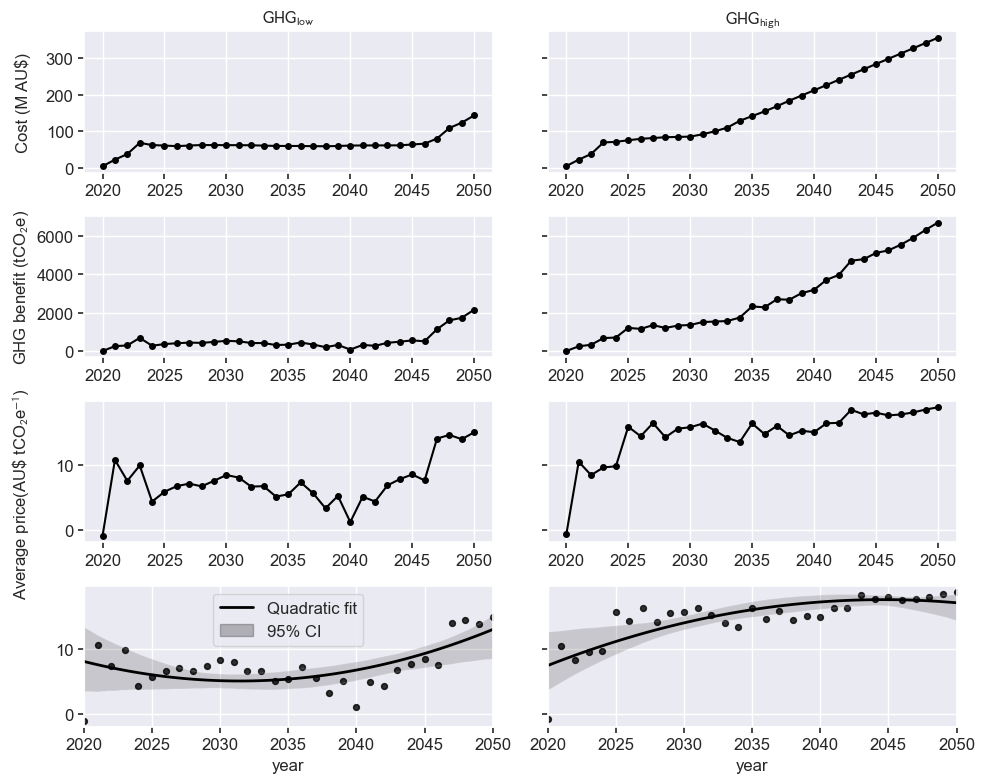

In [8]:
excel_dir = f"../../../output/{config.TASK_NAME}/carbon_price/1_excel"

carbon_names = ['carbon_low', 'carbon_high']
excel_carbon_paths = []
for name in carbon_names:
    excel_carbon_paths.append(os.path.join(excel_dir, f"2_{name}_cost_series.xlsx"))
plot_excels_as_grid(
    excel_paths=excel_carbon_paths,
    titles=['$\mathrm{GHG}_{\mathrm{low}}$', '$\mathrm{GHG}_{\mathrm{high}}$'],
    row_labels=["Cost (M AU$)", r"GHG benefit (tCO$_2$e)", r"Average price(AU\$ tCO$_2$e$^{-1}$)"],
    figsize=(10, 8),
    save_path=os.path.join(f"../../../output/{config.TASK_NAME}/carbon_price/2_figure", "2_carbon_cost_series.png")
)

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid e

✅ 图已保存：../../../output/20250908_Paper2_Results_NCI/carbon_price/2_figure\2_bio_cost_series.png


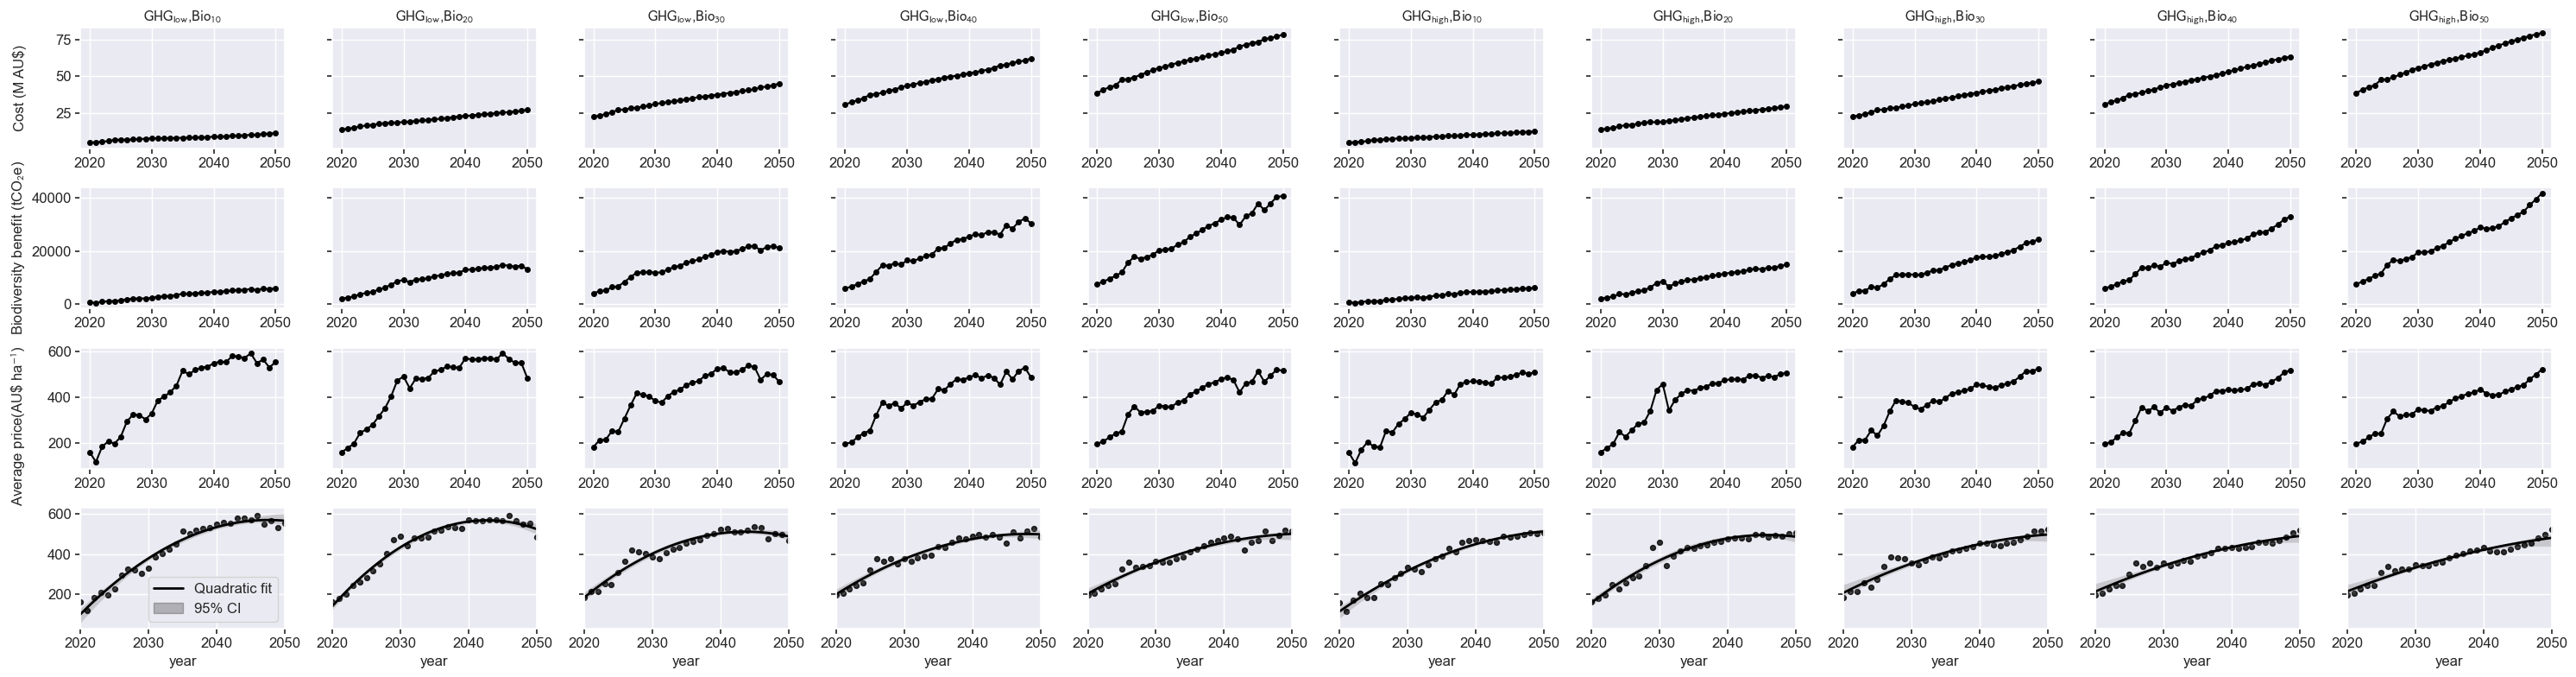

In [9]:
carbon_bio_names = [
        'carbon_low_bio_10', 'carbon_low_bio_20', 'carbon_low_bio_30', 'carbon_low_bio_40', 'carbon_low_bio_50',
        'carbon_high_bio_10', 'carbon_high_bio_20', 'carbon_high_bio_30', 'carbon_high_bio_40', 'carbon_high_bio_50'
    ]
excel_carbon_bio_paths = []
for name in carbon_bio_names:
    excel_carbon_bio_paths.append(os.path.join(excel_dir, f"2_{name}_cost_series.xlsx"))
plot_excels_as_grid(excel_carbon_bio_paths,
                   titles=[
                        '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{10}}$',
                        '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{20}}$',
                        '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{30}}$',
                        '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{40}}$',
                        '$\mathrm{GHG}_{\mathrm{low}}$,$\mathrm{Bio}_{\mathrm{50}}$',
                    
                        # --- High Group ---
                        '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{10}}$',
                        '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{20}}$',
                        '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{30}}$',
                        '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{40}}$',
                        '$\mathrm{GHG}_{\mathrm{high}}$,$\mathrm{Bio}_{\mathrm{50}}$'],
                    row_labels=["Cost (M AU$)", r"Biodiversity benefit (tCO$_2$e)", r"Average price(AU\$ ha$^{-1}$)"],
                    figsize=(30, 8),
                    save_path=os.path.join(f"../../../output/{config.TASK_NAME}/carbon_price/2_figure", "2_bio_cost_series.png"))